## Importing libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import tkinter as tk
from tkinter import ttk, END

import matplotlib.pyplot as plt

## Load dataset

In [4]:
movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")

movies_df.head(), ratings_df.head()

(   movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1       17     4.0  944249077
 1       1       25     1.0  944250228
 2       1       29     2.0  943230976
 3       1       30     5.0  944249077
 4       1       32     5.0  943228858)

In [5]:
movies_df.info(), ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB


(None, None)

### Data Visualization

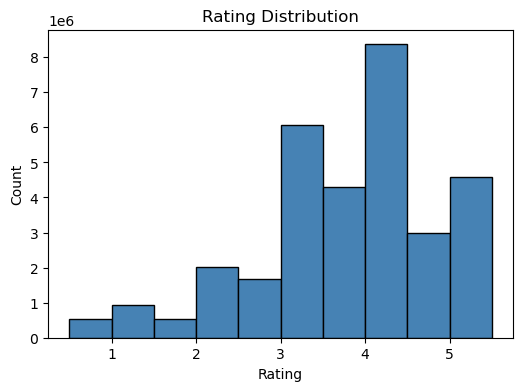

In [7]:
# 1. Overall rating distribution
plt.figure(figsize=(6, 4))
plt.hist(ratings_df['rating'], bins=np.arange(0.5, 5.6, 0.5), 
         edgecolor='black', color='steelblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

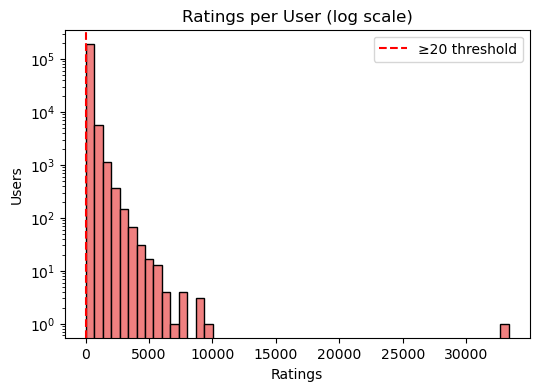

In [8]:
# 2. Ratings per user (log scale) + ≥20 threshold
user_counts = ratings_df['userId'].value_counts()
plt.figure(figsize=(6, 4))
plt.hist(user_counts, bins=50, edgecolor='black', color='lightcoral')
plt.yscale('log')
plt.axvline(20, color='red', linestyle='--', label='≥20 threshold')
plt.title('Ratings per User (log scale)')
plt.xlabel('Ratings')
plt.ylabel('Users')
plt.legend()
plt.show()

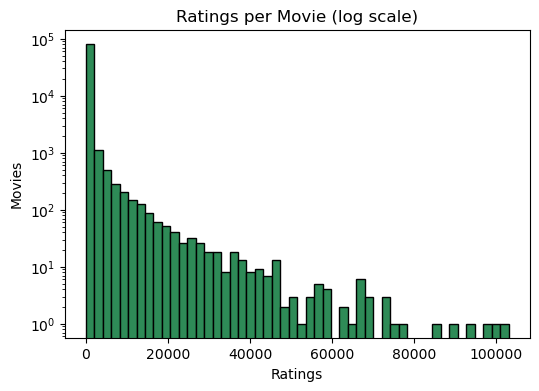

In [9]:
# 3. Ratings per movie (log scale)
movie_counts = ratings_df['movieId'].value_counts()
plt.figure(figsize=(6, 4))
plt.hist(movie_counts, bins=50, edgecolor='black', color='seagreen')
plt.yscale('log')
plt.title('Ratings per Movie (log scale)')
plt.xlabel('Ratings')
plt.ylabel('Movies')
plt.show()

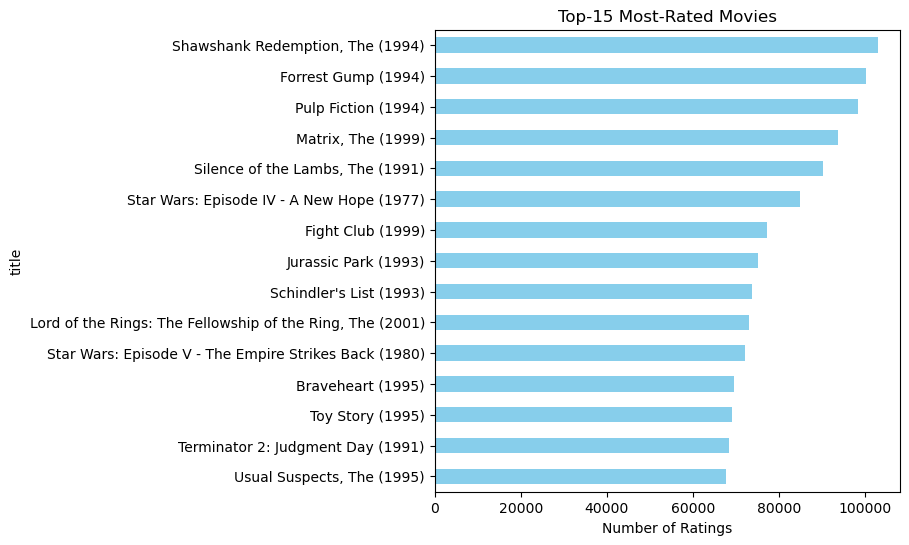

In [10]:
# 4. Top-15 most-rated movies
top_movies = (movie_counts.head(15)
              .to_frame('nRatings')
              .merge(movies_df[['movieId', 'title']], on='movieId')
              .set_index('title')['nRatings'])
plt.figure(figsize=(6, 6))
top_movies.plot.barh(color='skyblue')
plt.title('Top-15 Most-Rated Movies')
plt.xlabel('Number of Ratings')
plt.gca().invert_yaxis()
plt.show()

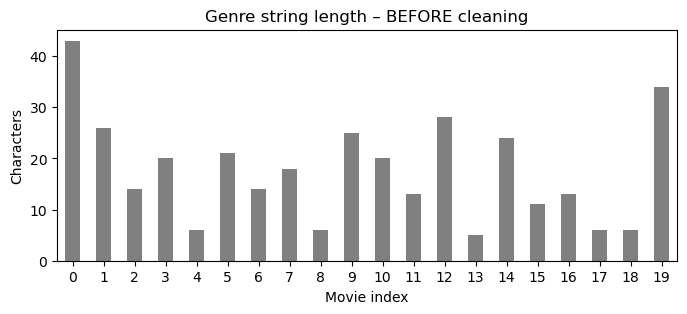

Movies with placeholder: 7080


In [11]:
# Why data preprocessing is require
# BEFORE: placeholder text still present
sample_before = movies_df['genres'].head(20).str.replace('|', ' ')
no_genre_mask = movies_df['genres'].str.contains('no genres listed', na=False)

plt.figure(figsize=(8,3))
pd.Series(sample_before).str.len().plot.bar(color='grey')
plt.title('Genre string length – BEFORE cleaning')
plt.xlabel('Movie index')
plt.ylabel('Characters')
plt.xticks(rotation=0)
plt.show()

print(f'Movies with placeholder: {no_genre_mask.sum()}')

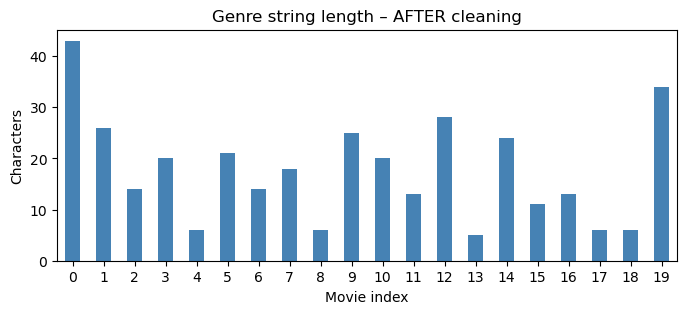

Empty genre strings left: 7080


In [12]:
# AFTER: placeholder removed
movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', '')
sample_after = movies_df['genres'].head(20).str.replace('|', ' ')

plt.figure(figsize=(8,3))
pd.Series(sample_after).str.len().plot.bar(color='steelblue')
plt.title('Genre string length – AFTER cleaning')
plt.xlabel('Movie index')
plt.ylabel('Characters')
plt.xticks(rotation=0)
plt.show()

print(f'Empty genre strings left: {(movies_df["genres"] == "").sum()}')

## Data preprocessing

In [14]:
movies_df["genres"] = movies_df["genres"].replace("(no genres listed)", "")

# Content-based filtering (CBF)

### TF-IDF on genres

In [17]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies_df["genres"])

In [18]:
# Map movieId → index
movie_indices = pd.Series(index=movies_df["movieId"], data=range(len(movies_df)))

### Content Based function

In [20]:
def recommend_cbf(user_id, K=10):
    user_movies = train_df[train_df["userId"] == user_id]["movieId"].values
    if len(user_movies) == 0:
        return []

    # pick first movie that exists in the mapping
    movie_idx = None
    for m in user_movies:
        if m in movie_indices:
            movie_idx = movie_indices[m]
            break
    if movie_idx is None:
        return []

    # compute similarity only for this one movie vs all movies
    sim_scores = linear_kernel(tfidf_matrix[movie_idx], tfidf_matrix).flatten()

    # rank high -> low
    similar_indices = np.argsort(sim_scores)[::-1]

    recommended = []
    watched = set(user_movies.tolist())

    for idx in similar_indices:
        mid = movies_df.iloc[idx]["movieId"]
        if mid not in watched:
            recommended.append(mid)
        if len(recommended) == K:
            break

    return recommended

# Collaborative Filtering (CF)

### Filter active users

In [23]:
# Keep users with at least 20 ratings
active_users = ratings_df["userId"].value_counts()
active_users = active_users[active_users >= 20].index

filtered_ratings = ratings_df[ratings_df["userId"].isin(active_users)]

In [24]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [25]:
filtered_ratings.shape

(32000204, 4)

In [26]:
# map userId and movieId to indices
user_ids = filtered_ratings["userId"].unique()
movie_ids = filtered_ratings["movieId"].unique()

user_map = {u: i for i, u in enumerate(user_ids)}
movie_map = {m: i for i, m in enumerate(movie_ids)}

filtered_ratings["user_idx"] = filtered_ratings["userId"].map(user_map)
filtered_ratings["movie_idx"] = filtered_ratings["movieId"].map(movie_map)

### Sparse user item matrix

In [28]:
user_item_sparse = csr_matrix(
    (filtered_ratings["rating"], (filtered_ratings["user_idx"], filtered_ratings["movie_idx"]))
)

In [29]:
knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=6)
knn.fit(user_item_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

### train test split per user

In [31]:
train_data = []
test_data = []

for user, group in filtered_ratings.groupby("userId"):
    if len(group) >= 5:
        train, test = train_test_split(group, test_size=0.2, random_state=42)
        train_data.append(train)
        test_data.append(test)

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

### Collaborative function

In [33]:
inv_user_map = {v: k for k, v in user_map.items()}
def recommend_cf(user_id, K=10):
    if user_id not in user_map:
        return []

    u_idx = user_map[user_id]
    user_movies = train_df[train_df["userId"] == user_id]["movieId"].values

    # Get top 5 similar users
    distances, indices = knn.kneighbors(user_item_sparse[u_idx], n_neighbors=6)
    similar_users_idx = indices.flatten()[1:]  # exclude self
    similarities = 1 - distances.flatten()[1:]

    # Gather ratings from similar users
    sim_user_ids = [inv_user_map[i] for i in similar_users_idx]
    sim_user_ratings = train_df[train_df["userId"].isin(sim_user_ids)]
    sim_user_ratings = sim_user_ratings[~sim_user_ratings["movieId"].isin(user_movies)]

    # Weight ratings by similarity
    scores = {}
    for i, sim_u in enumerate(sim_user_ids):
        user_ratings = sim_user_ratings[sim_user_ratings["userId"] == sim_u]
        for _, row in user_ratings.iterrows():
            scores[row.movieId] = scores.get(row.movieId, 0) + similarities[i] * row.rating

    return sorted(scores, key=scores.get, reverse=True)[:K]


## Popular movie function

In [35]:
def popular_movies_top(K=10):
    """Return the K highest-rated movies with at least 50 ratings."""
    movie_stats = (train_df
                   .groupby('movieId')['rating']
                   .agg(count='size', mean='mean')
                   .reset_index())
    movie_stats = movie_stats[movie_stats['count'] >= 50]
    top = movie_stats.sort_values('mean', ascending=False).head(K)
    return top['movieId'].tolist()

# Hybrid Recommendation System

In [37]:
def recommend_hybrid(user_id, K=10, alpha=0.7):
    if user_id not in user_map:          
        return popular_movies_top(K)
        
    cbf = recommend_cbf(user_id, K*2)
    cf  = recommend_cf (user_id, K*2)

    scores = {}
    for i, m in enumerate(cbf):
        scores[m] = scores.get(m, 0) + (1-alpha)*(len(cbf)-i)
    for i, m in enumerate(cf):
        scores[m] = scores.get(m, 0) + alpha*(len(cf)-i)

    return sorted(scores, key=scores.get, reverse=True)[:K]


# Evaluation metric

### Precison and recall

In [40]:
def get_relevant_items(user_id):
    return set(test_df[test_df["userId"] == user_id]["movieId"])

In [41]:
def precision_recall_at_k(recommended, relevant, K):
    recommended = recommended[:K]
    if not recommended or not relevant:
        return 0.0, 0.0
    hits = len(set(recommended) & relevant)
    precision = hits / K
    recall = hits / len(relevant)
    return precision, recall

### Evaluate CBF vs CF vs Hybrid

In [43]:
def evaluate_models(user_id, K=10):
    relevant = get_relevant_items(user_id)
    if len(relevant) == 0:
        return None

    cbf = recommend_cbf(user_id, K)
    cf = recommend_cf(user_id, K)
    hybrid = recommend_hybrid(user_id, K)

    return {
        "CBF": precision_recall_at_k(cbf, relevant, K),
        "CF": precision_recall_at_k(cf, relevant, K),
        "Hybrid": precision_recall_at_k(hybrid, relevant, K)
    }

### Avg result over multiple users

In [45]:
active_users = ratings_df["userId"].value_counts()
active_users = active_users[active_users >= 30].index[:20]  # limit to 20 users

results = {"CBF": [], "CF": [], "Hybrid": []}

for u in active_users:
    r = evaluate_models(u)
    if r:
        for k in results:
            results[k].append(r[k])

# Compute average results
final_results = {
    model: (np.mean([x[0] for x in results[model]]),
            np.mean([x[1] for x in results[model]]))
    for model in results
}

final_results

{'CBF': (0.05500000000000001, 0.0003580821504412475),
 'CF': (0.845, 0.005835301199354058),
 'Hybrid': (0.845, 0.005835301199354058)}

### Comparison table

In [47]:
comparison_df = pd.DataFrame({
    "Model": ["Content-Based", "Collaborative", "Hybrid"],
    "Precision@10": [final_results["CBF"][0], 
                     final_results["CF"][0], 
                     final_results["Hybrid"][0]],
    "Recall@10": [final_results["CBF"][1], 
                  final_results["CF"][1], 
                  final_results["Hybrid"][1]]
})

print(comparison_df)

           Model  Precision@10  Recall@10
0  Content-Based         0.055   0.000358
1  Collaborative         0.845   0.005835
2         Hybrid         0.845   0.005835


### Comparison graph

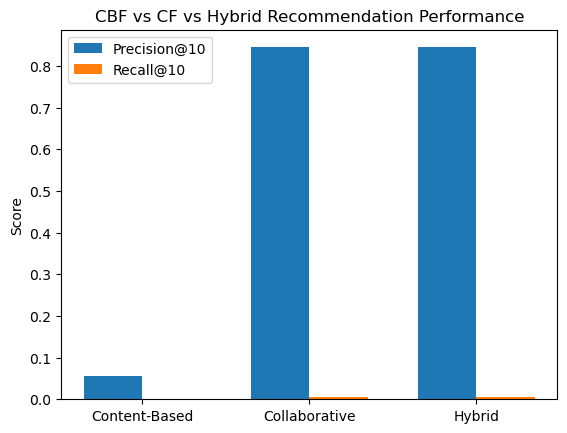

In [49]:
models = comparison_df["Model"]
precision = comparison_df["Precision@10"]
recall = comparison_df["Recall@10"]

x = np.arange(len(models))
width = 0.35

plt.figure()
plt.bar(x - width/2, precision, width, label="Precision@10")
plt.bar(x + width/2, recall, width, label="Recall@10")
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("CBF vs CF vs Hybrid Recommendation Performance")
plt.legend()
plt.show()

# List of recommended movies

In [51]:
def show_recommendations(movie_ids, movies_df, title="Recommended Movies"):
    if not movie_ids:
        print(title + ": No recommendations found")
        return []
    out = movies_df[movies_df["movieId"].isin(movie_ids)][["movieId", "title", "genres"]].copy()
    order = {mid: i for i, mid in enumerate(movie_ids)}
    out["rank"] = out["movieId"].map(order)
    out = out.sort_values("rank").drop(columns=["rank"])
    print(title); display(out.reset_index(drop=True))
    return out["title"].tolist()

In [52]:
user_id = 1
K = 10

cbf_ids = recommend_cbf(user_id, K)
cf_ids  = recommend_cf(user_id, K)
hy_ids  = recommend_hybrid(user_id, K)

show_recommendations(cbf_ids, movies_df, "CBF Recommendations")
show_recommendations(cf_ids, movies_df, "CF Recommendations")
show_recommendations(hy_ids, movies_df, "Hybrid Recommendations")

CBF Recommendations


,movieId,title,genres
0,196103,Crested Ibis (2017),Drama
1,245436,Baby For Sale (2004),Drama
2,184189,Mary Magdalene (2018),Drama
3,25914,"Ivan the Terrible, Part One (Ivan Groznyy I) (...",Drama
4,25915,"Southerner, The (1945)",Drama
5,128860,Beau Brummell: This Charming Man (2006),Drama
6,87888,Westward Passage (1932),Drama
7,245486,Pledge of Allegiance (2003),Drama
8,245478,Kush (2007),Drama
9,25918,"Tree Grows in Brooklyn, A (1945)",Drama


CF Recommendations


,movieId,title,genres
0,858,"Godfather, The (1972)",Crime|Drama
1,1193,One Flew Over the Cuckoo's Nest (1975),Drama
2,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
3,2858,American Beauty (1999),Drama|Romance
4,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
5,1207,To Kill a Mockingbird (1962),Drama
6,1956,Ordinary People (1980),Drama
7,2248,Say Anything... (1989),Comedy|Drama|Romance
8,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
9,1299,"Killing Fields, The (1984)",Drama|War


Hybrid Recommendations


,movieId,title,genres
0,858,"Godfather, The (1972)",Crime|Drama
1,1193,One Flew Over the Cuckoo's Nest (1975),Drama
2,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
3,2858,American Beauty (1999),Drama|Romance
4,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi
5,1207,To Kill a Mockingbird (1962),Drama
6,1956,Ordinary People (1980),Drama
7,2248,Say Anything... (1989),Comedy|Drama|Romance
8,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
9,1299,"Killing Fields, The (1984)",Drama|War


['Godfather, The (1972)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'L.A. Confidential (1997)',
 'American Beauty (1999)',
 '2001: A Space Odyssey (1968)',
 'To Kill a Mockingbird (1962)',
 'Ordinary People (1980)',
 'Say Anything... (1989)',
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 'Killing Fields, The (1984)']

In [53]:
user_id = 123456789
K = 10

hy_ids  = recommend_hybrid(user_id, K)
show_recommendations(hy_ids, movies_df, "Hybrid Recommendations")

Hybrid Recommendations


,movieId,title,genres
0,159817,Planet Earth (2006),Documentary
1,171011,Planet Earth II (2016),Documentary
2,170705,Band of Brothers (2001),Action|Drama|War
3,318,"Shawshank Redemption, The (1994)",Crime|Drama
4,171495,Cosmos,
5,858,"Godfather, The (1972)",Crime|Drama
6,202439,Parasite (2019),Comedy|Drama
7,179135,Blue Planet II (2017),Documentary
8,198185,Twin Peaks (1989),Drama|Mystery
9,1203,12 Angry Men (1957),Drama


['Planet Earth (2006)',
 'Planet Earth II (2016)',
 'Band of Brothers (2001)',
 'Shawshank Redemption, The (1994)',
 'Cosmos',
 'Godfather, The (1972)',
 'Parasite (2019)',
 'Blue Planet II (2017)',
 'Twin Peaks (1989)',
 '12 Angry Men (1957)']

# Tkinter GUI

In [55]:
def run_gui():
    root = tk.Tk()
    root.title("Hybrid Movie Recommender")
    root.geometry("400x320")

    ttk.Label(root, text="User ID:").grid(row=0, column=0, padx=10, pady=10, sticky="w")
    uid_entry = ttk.Entry(root, width=12)
    uid_entry.grid(row=0, column=1, padx=10)

    listbox = tk.Listbox(root, height=12, width=55)
    listbox.grid(row=2, column=0, columnspan=2, padx=10, pady=10)
    scroll = ttk.Scrollbar(root, orient="vertical", command=listbox.yview)
    listbox.configure(yscrollcommand=scroll.set)
    scroll.grid(row=2, column=2, sticky="ns")

    def recommend():
        listbox.delete(0, END)
        try:
            user = int(uid_entry.get())
            if user <= 0:                      
                listbox.insert(END, "Enter a valid integer User ID")
                return
                
            ids = recommend_hybrid(user, K=10)
            titles = show_recommendations(ids, movies_df, "Hybrid Recommendations")
            
            for t in titles:
                listbox.insert(END, t)
        except ValueError:
            listbox.insert(END, "Enter a valid integer User ID")

    ttk.Button(root, text="Recommend", command=recommend).grid(row=1, column=0, columnspan=2, pady=6)
    root.mainloop()

In [56]:
run_gui()

Hybrid Recommendations


,movieId,title,genres
0,339,While You Were Sleeping (1995),Comedy|Romance
1,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
3,3159,Fantasia 2000 (1999),Animation|Children|Musical|IMAX
4,61267,Fly Me to the Moon (2008),Adventure|Animation|Children|IMAX
5,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
6,48414,Open Season (2006),Adventure|Animation|Children|Comedy|IMAX
7,49274,Happy Feet (2006),Adventure|Animation|Children|Comedy|IMAX
8,318,"Shawshank Redemption, The (1994)",Crime|Drama
9,87876,Cars 2 (2011),Adventure|Animation|Children|Comedy|IMAX
